In [242]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import cv2
from itertools import product
from PIL import Image

import os

In [273]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

# Dataset

In [274]:
class ExoDataset(Dataset):
    def __init__(self, dataset_path):
        super().__init__()
        dataset_path = os.path.join(dataset_path, '*.npy')
        self.image_paths = glob(dataset_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        
        image = self.image_paths[idx]
        image = np.load(image).astype(np.float32)

        if 'fc' in self.image_paths[idx]:
            label = torch.ones(1)
        else:
            label = torch.zeros(1)

        image = torch.from_numpy(image).unsqueeze(0)
        return (image, label)



In [275]:
dataset_path = '/data/scratch/bariskurtkaya/dataset/NIRCAM/train/train_test/injections'
batch_size = 256

train_loader = DataLoader(ExoDataset(dataset_path), batch_size=batch_size, shuffle=True)

# Model

In [291]:
class ExoModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.init_model()

    def init_model(self):
        # Input x -> B, 1, H, W

        self.conv1 = nn.Conv2d(1, 16, 3, stride=1, padding=1)

        conv_layer = nn.Sequential(
            nn.Conv2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU()
        )

        self.cnn =  nn.ModuleList([conv_layer for _ in range(3)])

        self.conv2 = nn.Conv2d(16, 1, 3, stride=1, padding=1)

        self.linear = nn.Sequential(
            nn.Linear(80*80, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def init_weights(self):
        pass

    def forward(self, x):
        # x --> B, 1, H, W
        # y_gt --> B, 1
        
        B = x.shape[0]
        x = F.relu(self.conv1(x))

        for idx, layer in enumerate(self.cnn):
            x = layer(x)

        x = F.relu(self.conv2(x))

        x = x.view(B, -1)
        y_pred = self.linear(x)
        return torch.sigmoid(y_pred) # B, 1


    def loss(self, y_pred, y_gt):
        # y_pred = self.forward(x)
        return F.binary_cross_entropy(y_pred, y_gt)

    def accuracy(self, y_pred, y_gt):
        y = y_pred.clone()
        y[y_pred>0.7] = 1
        y[y_pred<0.3] = 0

        acc = torch.sum(y == y_gt)
        return acc / y_pred.shape[0]

# Training

In [292]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

lr = 1e-3
num_epochs = 30

model = ExoModel().to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

In [293]:
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    loss_list = []
    acc_list = []

    for _, batch in enumerate(train_loader):
        data, label = batch
        data = data.to(device)
        
        label = label.to(device).float()
        optimizer.zero_grad()
        
        y_pred = model(data)
        loss = model.loss(y_pred, label)
        acc = model.accuracy(y_pred, label)
        assert float('nan') != loss.item()

        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        acc_list.append(acc.item())

    return loss_list, acc_list

In [294]:
epochs = tqdm(range(num_epochs))

torch.autograd.set_detect_anomaly(False)

train_losses = []
accs = []

for epoch_idx in epochs:
    loss_list, acc_list = train_epoch(model, train_loader, optimizer, device)

    train_losses.extend(loss_list)
    accs.extend(acc_list)

    epochs.set_postfix(epoch=epoch_idx, train_loss=train_losses[-1], acc_list = accs[-1])

  0%|          | 0/30 [00:00<?, ?it/s]

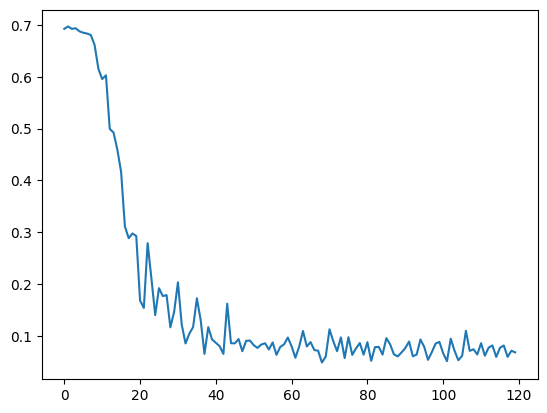

In [295]:
epoch_array = torch.arange(torch.Tensor(train_losses).shape[0])

plt.plot(epoch_array, train_losses)

plt.show()

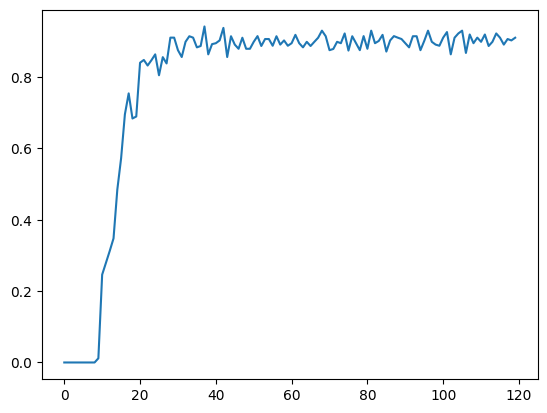

In [296]:
epoch_array = torch.arange(torch.Tensor(accs).shape[0])

plt.plot(epoch_array, accs)

plt.show()

# Visualization